In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from model import U_Net_PlusPlus

model = U_Net_PlusPlus(256,256,1,deep_supervision=True)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 256, 256, 32) 320         input[0][0]                      
__________________________________________________________________________________________________
bn11_1 (BatchNormalization)     (None, 256, 256, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
relu11_1 (Activation)           (None, 256, 256, 32) 0           bn11_1[0][0]                     
_______________________________________________________________________________________

In [6]:
from keras_preprocessing.image import ImageDataGenerator
from functions import clear_blank_mask, make_model_input
from TFRecord_func import TFRecord_to_data

tfrecord_train_path = "../jupyter_data/tfrecord/enface/batch1"
train_image, train_mask, _ = TFRecord_to_data(tfrecord_train_path)

X_train_tmp, num_patches_perimage = make_model_input(train_image, do_norm=True, data_shape=(-1, 256, 256, 1))
y_train_tmp, _ = make_model_input(train_mask, do_norm=False, data_shape=(-1, 256, 256, 1))

print(num_patches_perimage)

print("X_train shape:{}".format(X_train_tmp.shape))
print("y_train shape:{}".format(y_train_tmp.shape))

X_train, y_train = clear_blank_mask(X_train_tmp, y_train_tmp, ratio_of_blank=0.2)

print("Clear blank mask")
print("X_train shape:{}".format(X_train.shape))
print("y_train shape:{}".format(y_train.shape))

print("X_train dataType:{}".format(X_train.dtype))
print("y_train dataType:{}".format(y_train.dtype))

 8/10 [=======================>......] - ETA: 0s[9, 16, 16, 9, 16, 25, 9, 9, 16, 4]
X_train shape:(129, 256, 256, 1)
y_train shape:(129, 256, 256, 1)
Clear blank mask
X_train shape:(99, 256, 256, 1)
y_train shape:(99, 256, 256, 1)
X_train dataType:float64
y_train dataType:bool


In [16]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

image_datagen = datagen.flow(X_train, shuffle=False, seed=100, batch_size=1)
mask_datagen = datagen.flow(y_train, shuffle=False, seed=100, batch_size=1)

In [20]:
#filp image
import tensorflow as tf

ver_X_train = tf.image.flip_up_down(X_train)
ver_y_train = tf.image.flip_up_down(y_train)

hor_X_train = tf.image.flip_left_right(X_train)
hor_y_train = tf.image.flip_left_right(y_train)

new_X_train = tf.image.flip_left_right(ver_X_train)
new_y_train = tf.image.flip_left_right(ver_y_train)


In [22]:
aug_X_train = tf.concat([X_train, ver_X_train, hor_X_train, new_X_train], axis=0)
aug_y_train = tf.concat([y_train, ver_y_train, hor_y_train, new_y_train], axis=0)

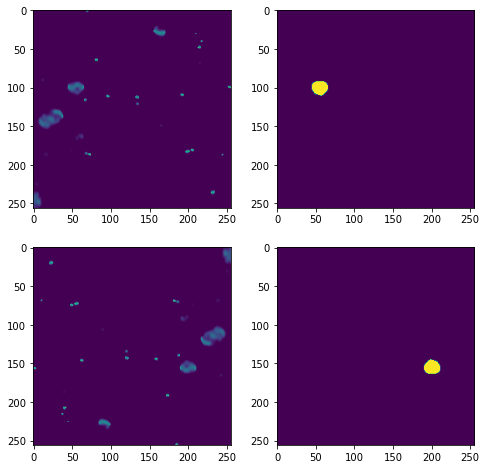

In [35]:
import matplotlib.pyplot as plt
import random

r = random.randint(0, len(aug_X_train))
plt.figure(figsize=(8, 8))
k = r % 99
plt.subplot(221)
plt.imshow(aug_X_train[k].numpy().reshape((256, 256)))
plt.subplot(222)
plt.imshow(aug_y_train[k].numpy().reshape((256, 256)))

plt.subplot(223)
plt.imshow(aug_X_train[r].numpy().reshape((256, 256)))
plt.subplot(224)
plt.imshow(aug_y_train[r].numpy().reshape((256, 256)))

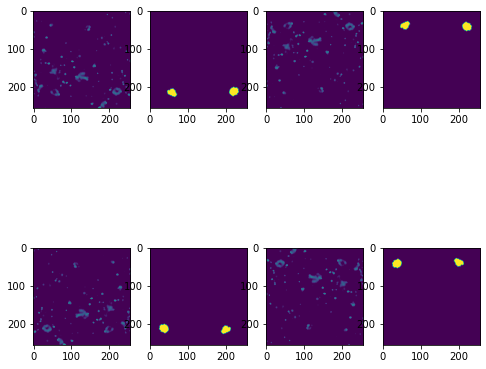

In [21]:
import matplotlib.pyplot as plt

r = 0
plt.figure(figsize=(8, 8))
# image, mask = image_datagen.next(), mask_datagen.next()
plt.subplot(2, 4, 1)
plt.imshow(X_train[r].reshape((256, 256)))
plt.subplot(2, 4, 2)
plt.imshow(y_train[r].reshape((256, 256)))

plt.subplot(2, 4, 3)
plt.imshow(ver_X_train[r].numpy().reshape((256, 256)))
plt.subplot(2, 4, 4)
plt.imshow(ver_y_train[r].numpy().reshape((256, 256)))

plt.subplot(2, 4, 5)
plt.imshow(hor_X_train[r].numpy().reshape((256, 256)))
plt.subplot(2, 4, 6)
plt.imshow(hor_y_train[r].numpy().reshape((256, 256)))

plt.subplot(2, 4, 7)
plt.imshow(new_X_train[r].numpy().reshape((256, 256)))
plt.subplot(2, 4, 8)
plt.imshow(new_y_train[r].numpy().reshape((256, 256)))

plt.show()

In [36]:
tfrecord_test_path = "../data/test"
test_image, test_mask, _ = TFRecord_to_data(tfrecord_test_path)

X_test, _ = make_model_input(test_image, do_norm=True, data_shape=(-1, 256, 256, 1))
y_test, _ = make_model_input(test_mask, do_norm=False, data_shape=(-1, 256, 256, 1))

13/15 [=========================>....] - ETA: 0s

In [40]:
from keras.models import load_model
from metrics import *

model_path = "../model/valDice0.6752_valMeanIoU0.5303.h5"
model = load_model(model_path, compile=False)
model.compile(loss=bce_dice_loss,
              metrics=["binary_crossentropy", mean_iou, dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 256, 256, 32) 320         input[0][0]                      
__________________________________________________________________________________________________
bn11_1 (BatchNormalization)     (None, 256, 256, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
relu11_1 (Activation)           (None, 256, 256, 32) 0           bn11_1[0][0]                     
______________________________________________________________________________________________

In [43]:
y_pred = model.predict(X_test, verbose=1)

6/6 [==============================] - 13s 2s/step


149


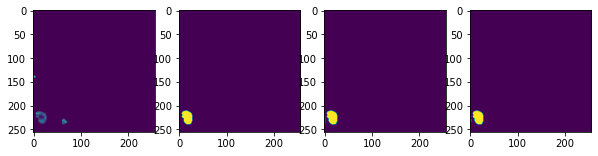

132


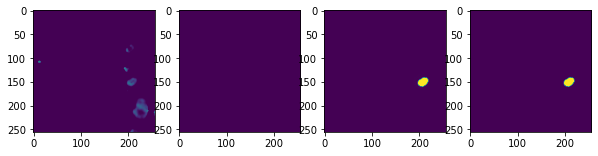

175


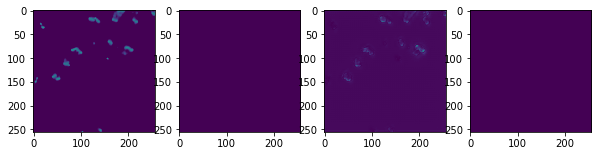

66


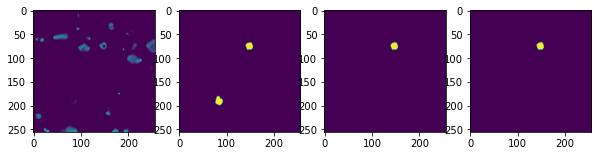

41


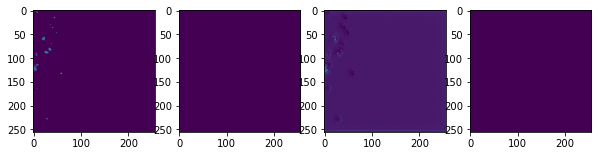

42


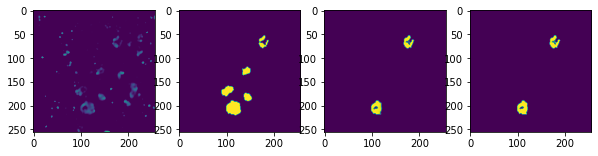

110


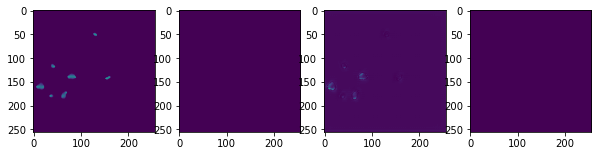

63


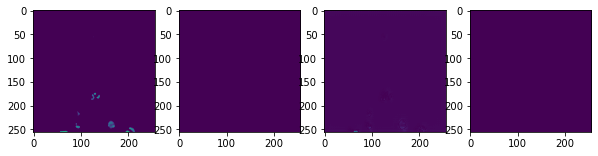

76


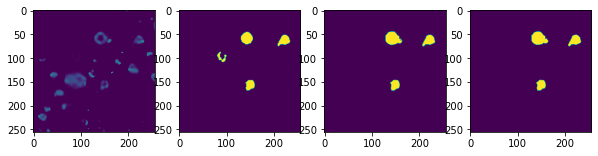

49


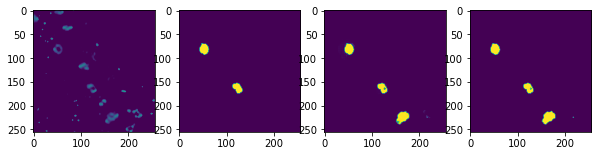

In [59]:
import matplotlib.pyplot as plt
import random

for _ in range(10):
    r = random.randint(0, len(y_pred))
    print(r)
    plt.figure(figsize=(10, 10))

    plt.subplot(141)
    plt.imshow(X_test[r].reshape((256, 256)))
    plt.subplot(142)
    plt.imshow(y_test[r].reshape((256, 256)))

    plt.subplot(143)
    plt.imshow(y_pred[r].reshape((256, 256)))

    plt.subplot(144)
    plt.imshow(np.array(y_pred[r] > 0.3).reshape((256, 256)))

    plt.show()

In [61]:
from metrics import  mean_iou
print(mean_iou([0,0,0,0],[0,0,0,0]))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
tf.Tensor(0, shape=(), dtype=int32)
